In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
fs = 14
ts = 16

plt.rc('xtick', labelsize=fs) 
plt.rc('ytick', labelsize=fs) 
plt.rc("font", size = fs)

In [3]:
def convert_currency(amount):

    number = float(re.search(r'\s(\d+\.\d+)', amount).group(1))

    currency = amount[:3]
    if currency != "EUR":
        if currency == "BOB":
            conv = 8.3725
        elif currency == "DKK":
            conv = 7.4374
        elif currency == "GEL":
            conv = 3.8279
        elif currency == "INR":
            conv = 88.6972
        elif currency == "JOD":
            conv = 0.8585
        elif currency == "KES":
            conv = 130.5909
        elif currency == "LKR":
            conv = 239.5998
        elif currency == "NGN":
            conv = 498.8897
        elif currency == "NPR":
            conv = 142.5807
        elif currency == "TRY":
            conv = 10.1572
        elif currency == "USD":
            conv = 1.2108
        elif currency == "ZAR":
            conv = 16.6102
        else:
            print("warning, non-defined currency in dataset")
            conv = 1

        number = number / conv

    return number

def check_search_term(description, search_terms):
    for term in search_terms:
        if term in description:
            return 1
    return 0

In [4]:
#Reading the data
folder = Path("/Users/nielskreuk/Dropbox/DataScience/Exercises/NYCDSA/ScrapingProject/fmo/scrapeddata")
file_to_open = folder / "fmo.csv"
cols = pd.read_csv(file_to_open, sep=";", nrows=1).columns
df = pd.read_csv(file_to_open, sep=";", usecols=cols[:6]) #Leave out couple of empty columns at end of file

In [5]:
#add a column with converted amounts in EUR as numbers
df["mEUR_amounts"] = [convert_currency(amount) for amount in df["amount"]]

In [6]:
#Remove the 3 extreme outliers. Run this only once!
outliers = df.nlargest(3,"mEUR_amounts").index
df.drop(index = outliers, inplace = True)

In [7]:
#Test investments for being other fund rather than direct
search_terms = ["fund", "vehicle"]
df["fund"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test climate
search_terms = ["green", "renewable", "climate", "sustainable", "environmental"]
df["climate"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test economic growth
search_terms = ["economic growth", " gdp growth", "economic development", "emerging", "upcoming", "efficiency", "readily available", "ecosystem", "infrastructure", "financial institution"]
df["economic_growth"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test economic inclusion
search_terms = ["inclusive", "inclusion", "affordable housing", "empowerment", "microfinance", "smallholder", "ineqaulity", "sme", "smes", "small and medium sized enterprise", "family-owned", "low-income", "job opportunities", "mid-market", "middle-market", "early stage", "unemployment", "local enterprise", "medium-sized", "lower mid-cap"]
df["inclusion"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test gender
search_terms = ["gender", "female", "women"]
df["gender"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test human rights
search_terms = ["equal rigths", "human rights", "justice", "governance", "labor standards", "hse"]
df["human_rights"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test education
search_terms = ["education"]
df["education"] = [check_search_term(description, search_terms) for description in df["description"]]

#Test food security
search_terms = ["food security", "hunger", "clean water", "drinking water"]
df["food_security"] = [check_search_term(description, search_terms) for description in df["description"]]


#Check multi-goal investments
df["num_goals"] = df["inclusion"] + df["food_security"] + df["climate"] + df["gender"] + df["human_rights"] + df["education"] + df["economic_growth"]
mask_multi = (df["num_goals"] > 1)
mask_noGoals = (df["num_goals"] == 0)

In [8]:
#Sort per year
df["year"] = [int(date[-4:]) for date in df["date"]]

In [9]:
df.columns

Index(['amount', 'country', 'date', 'description', 'industry', 'project_name',
       'mEUR_amounts', 'fund', 'climate', 'economic_growth', 'inclusion',
       'gender', 'human_rights', 'education', 'food_security', 'num_goals',
       'year'],
      dtype='object')

In [10]:
#Grab counting columns
num_projects_goal = df.iloc[: , 8:15]

#Calculate amount columns
amounts_goal = num_projects_goal.mul(df["mEUR_amounts"], axis=0) 

In [11]:
category_sums = amounts_goal.sum(axis=0)
category_sums_single = amounts_goal.mul((df["num_goals"] == 1), axis=0).sum(axis=0)
single_fraction = category_sums_single / category_sums
single_fraction.sort_values(ascending=False, inplace=True)
single_fraction = np.array(single_fraction).reshape(-1,1).T
single_fraction = pd.DataFrame(single_fraction, columns = ["climate", "economic_growth", "inclusion", "gender", "human_rights", "education", "food_security"])

In [12]:
#Calculate distribution over goals per year
num_projects_goal_year = df[df["year"] > 2012].iloc[: , [8,9,10,11,12,13,14,16]].groupby("year").sum()
amounts_goal_year = df[df["year"] > 2012].iloc[: , 8:15].mul(df["mEUR_amounts"], axis=0)
amounts_goal_year["year"] = df[df["year"] > 2012]["year"]
amounts_goal_year["total"]=df[df["year"] > 2012]["mEUR_amounts"]
amounts_goal_year = amounts_goal_year.groupby("year").sum()
fraction_goal_year = amounts_goal_year.iloc[: , :7].div(amounts_goal_year["total"], axis=0)
amounts_goal_year = amounts_goal_year.iloc[: , :7]

In [13]:
#Write file
file_to_write = folder / "fmo_categorized.csv"
df.to_csv(file_to_write, sep=";")

In [14]:
print(df["num_goals"].sum())

1753


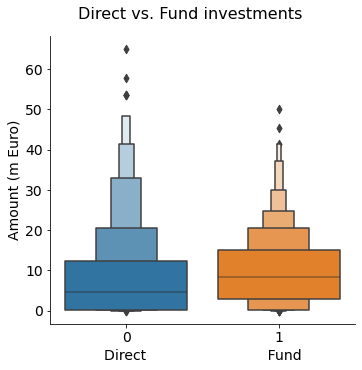

In [15]:
boxen = sns.catplot(x="fund", y="mEUR_amounts", kind="boxen", data=df, showfliers = True)
plt.subplots_adjust(top=0.9)
boxen.fig.suptitle('Direct vs. Fund investments', fontsize = ts)
plt.ylabel("Amount (m Euro)", size = fs)
plt.xlabel("Direct                           Fund")
plt.show()

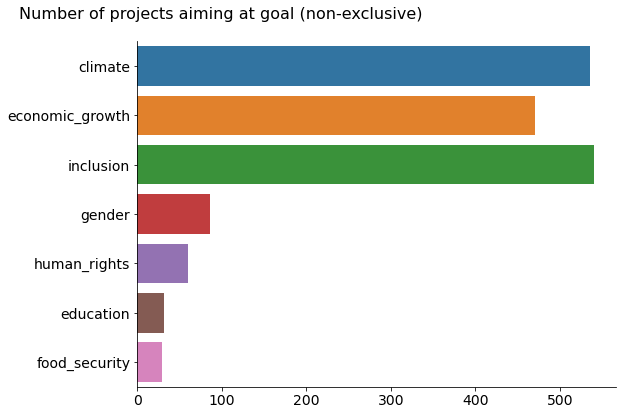

In [16]:
bars = sns.catplot(kind="bar", data=num_projects_goal, ci = None, estimator=sum, orient = "h")
plt.subplots_adjust(top=0.9)
bars.fig.suptitle("Number of projects aiming at goal (non-exclusive)", fontsize = ts)
bars.fig.set_figheight(6)
bars.fig.set_figwidth(12)
plt.show()

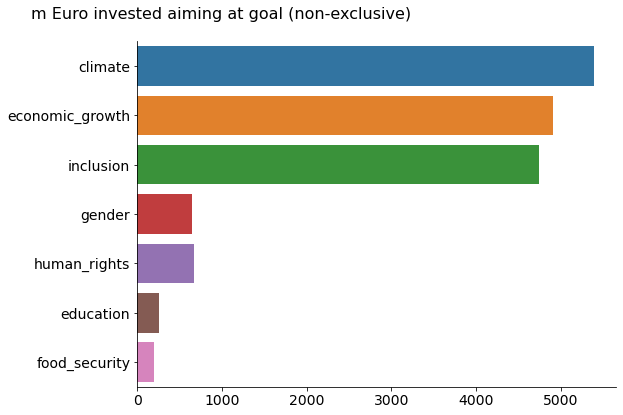

In [17]:
bars = sns.catplot(kind="bar", data=amounts_goal, ci = None, estimator=sum, orient = "h")
plt.subplots_adjust(top=0.9)
bars.fig.suptitle("m Euro invested aiming at goal (non-exclusive)", fontsize = ts)
bars.fig.set_figheight(6)
bars.fig.set_figwidth(12)
plt.show()

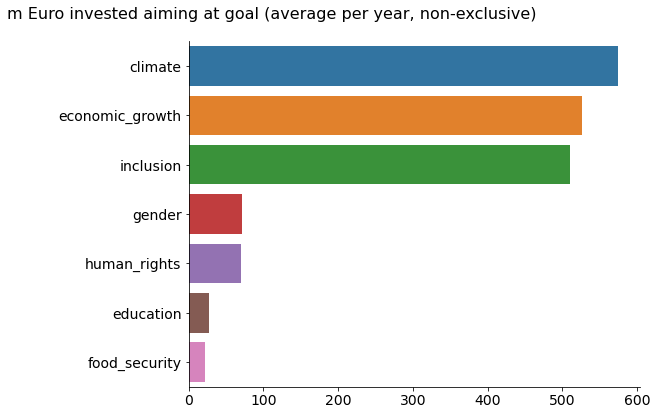

In [18]:
bars = sns.catplot(kind="bar", data=amounts_goal_year, ci = None, orient = "h")
plt.subplots_adjust(top=0.9)
bars.fig.suptitle("m Euro invested aiming at goal (average per year, non-exclusive)", fontsize = ts)
bars.fig.set_figheight(6)
bars.fig.set_figwidth(12)
plt.show()

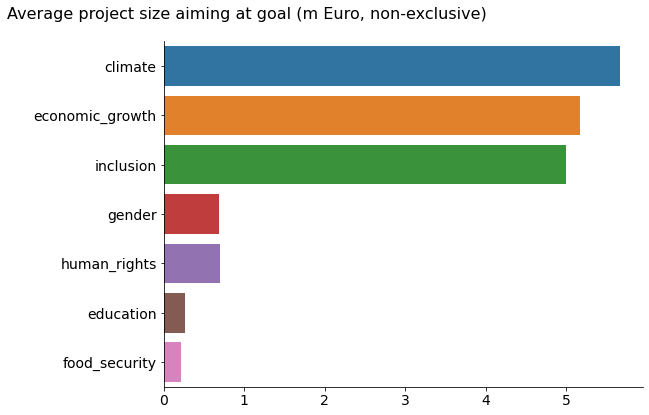

In [19]:
bars = sns.catplot(kind="bar", data=amounts_goal, ci = None, orient = "h")
plt.subplots_adjust(top=0.9)
bars.fig.suptitle("Average project size aiming at goal (m Euro, non-exclusive)", fontsize = ts)
bars.fig.set_figheight(6)
bars.fig.set_figwidth(12)
plt.show()

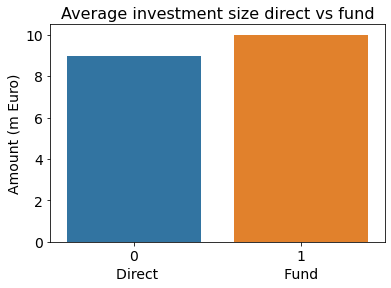

In [20]:
bars = sns.barplot(data=df, x="fund", y="mEUR_amounts", ci = None)
bars.set_ylabel( "Amount (m Euro)")
bars.set_xlabel( "Direct                            Fund")
bars.set_title("Average investment size direct vs fund", fontsize = ts)
plt.show()

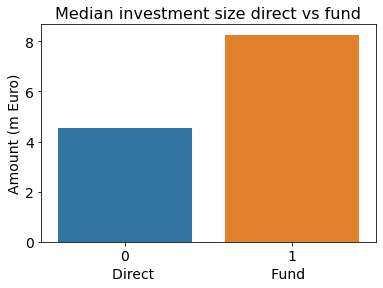

In [21]:
bars = sns.barplot(data=df, x="fund", y="mEUR_amounts", ci = None,estimator=np.median)
bars.set_ylabel( "Amount (m Euro)")
bars.set_xlabel( "Direct                          Fund")
bars.set_title("Median investment size direct vs fund", fontsize = ts)
plt.show()

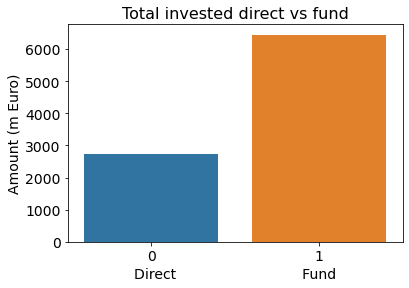

In [22]:
bars = sns.barplot(data=df, x="fund", y="mEUR_amounts", ci = None, estimator=sum)
bars.set_ylabel( "Amount (m Euro)")
bars.set_xlabel( "Direct                            Fund")
bars.set_title("Total invested direct vs fund", fontsize = ts)
plt.show()

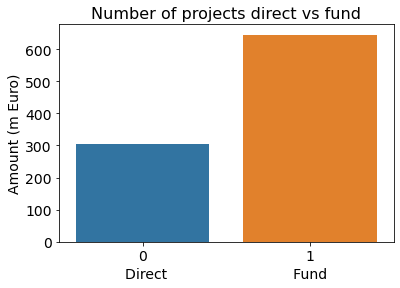

In [23]:
bars = sns.countplot(data=df, x="fund")
bars.set_ylabel( "Amount (m Euro)")
bars.set_xlabel( "Direct                            Fund")
bars.set_title("Number of projects direct vs fund", fontsize = ts)
plt.show()

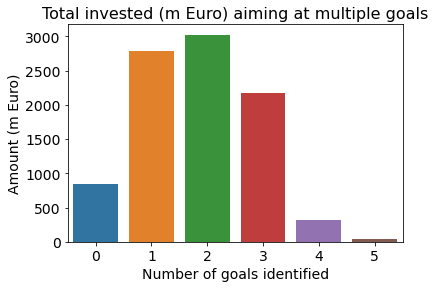

In [24]:
bars = sns.barplot(data=df, x="num_goals", y="mEUR_amounts", ci = None,estimator=sum)
bars.set_ylabel( "Amount (m Euro)")
bars.set_xlabel( "Number of goals identified")
bars.set_title("Total invested (m Euro) aiming at multiple goals", fontsize = ts)
plt.show()

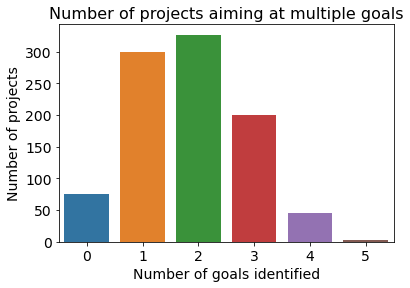

In [25]:
bars = sns.countplot(data=df, x="num_goals")
bars.set_ylabel( "Number of projects")
bars.set_xlabel( "Number of goals identified")
bars.set_title("Number of projects aiming at multiple goals", fontsize = ts)
plt.show()

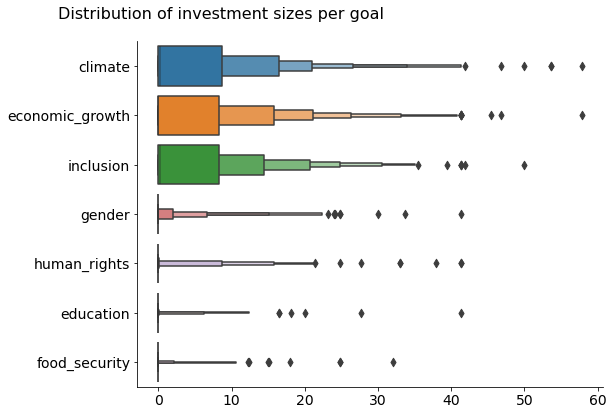

In [30]:
boxen = sns.catplot(kind="boxen", data=amounts_goal, showfliers = True, orient = "h")
plt.subplots_adjust(top=0.9)
boxen.fig.suptitle("Distribution of investment sizes per goal", fontsize = ts)
boxen.fig.set_figheight(6)
boxen.fig.set_figwidth(12)
plt.show()

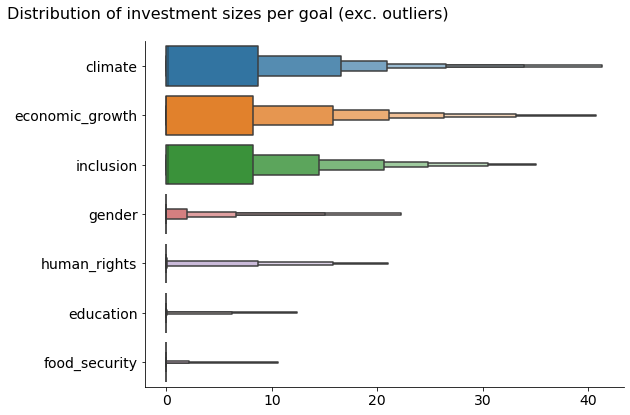

In [31]:
boxen = sns.catplot(kind="boxen", data=amounts_goal, showfliers = False, orient = "h")
plt.subplots_adjust(top=0.9)
boxen.fig.suptitle("Distribution of investment sizes per goal (exc. outliers)", fontsize = ts)
boxen.fig.set_figheight(6)
boxen.fig.set_figwidth(12)
plt.show()

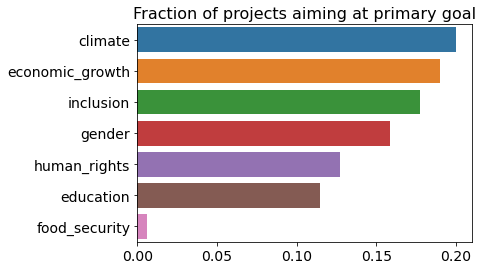

In [33]:
bars = sns.barplot(data=single_fraction, ci = None, orient = "h",)
bars.set_title("Fraction of projects aiming at primary goal", fontsize = ts )

plt.show()

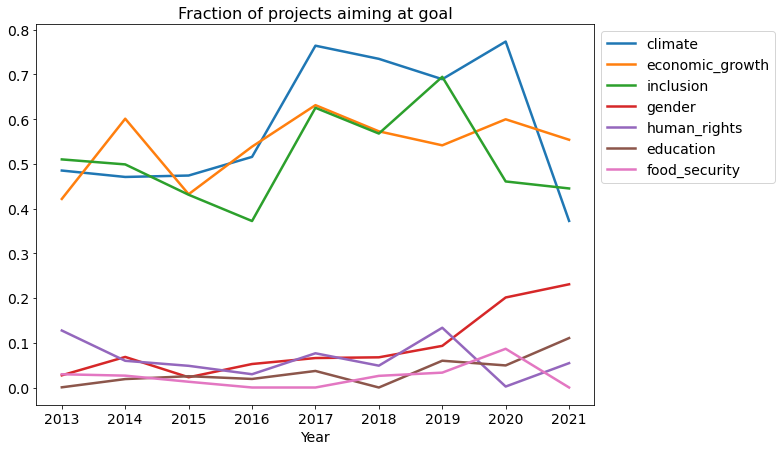

In [29]:
bars = fraction_goal_year.plot(kind="line", figsize = (10,7), lw=2.5)
bars.set_title("Fraction of projects aiming at goal", fontsize = ts)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Year")
plt.show()